## Import Libraries

In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from IPython.display import Audio
# import resampy

## Extract Data

In [2]:
path = "kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24"

In [3]:
#happens sometimes 
#if '.DS_Store' in os.listdir("data"):
#    os.remove('data/.DS_Store')

    
#extract file values 
directory_list = os.listdir(path)

file_emotion = []
file_path = []
file_gender = []
file_intensity = []
file_line = []


for dir in directory_list:
    
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(path,dir))
    
    for file in actor:
        part = file.split('.')
        part = part[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_intensity.append(0 if int(part[3]) == 1 else 1) #0 is normal and 1 is strong
        file_line.append("Kids are talking by the door" if int(part[4]) == 1 else "Dogs are sitting by the door")
        file_path.append(os.path.join(path,dir,file))
        file_gender.append(0 if int(dir.split('_')[1]) %2 == 1 else 1) #0 is male and 1 is female
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for gender of actor
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

#dataframe for emotional intensity
intensity_df = pd.DataFrame(file_intensity, columns=['Intensity'])

#dataframe for sentences spoken
line_df = pd.DataFrame(file_line, columns=['Line'])


#main df
df = pd.concat([path_df, emotion_df, gender_df, intensity_df, line_df], axis=1)

# changing integers to actual emotions.
df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
df.to_csv("data_clean.csv")

df.head()

Path Emotions  Gender  \
0  kaggle/input/ravdess-emotional-speech-audio/au...    angry       1   
1  kaggle/input/ravdess-emotional-speech-audio/au...     fear       1   
2  kaggle/input/ravdess-emotional-speech-audio/au...     fear       1   
3  kaggle/input/ravdess-emotional-speech-audio/au...    angry       1   
4  kaggle/input/ravdess-emotional-speech-audio/au...  disgust       1   

   Intensity                          Line  
0          0  Dogs are sitting by the door  
1          0  Dogs are sitting by the door  
2          1  Kids are talking by the door  
3          1  Kids are talking by the door  
4          0  Kids are talking by the door

### Read file
Use `head` and `tail` to retrieve the top and bottom `n` rows. Use `sample` to randomly view `5` rows

In [ ]:
df = pd.read_csv("data_clean.csv")
df.head()

Unnamed: 0                                               Path Emotions  \
0           0  C:/Users/Huai/Documents/GitHub/is460-g2/kaggle...  neutral   
1           1  C:/Users/Huai/Documents/GitHub/is460-g2/kaggle...  neutral   
2           2  C:/Users/Huai/Documents/GitHub/is460-g2/kaggle...  neutral   
3           3  C:/Users/Huai/Documents/GitHub/is460-g2/kaggle...  neutral   
4           4  C:/Users/Huai/Documents/GitHub/is460-g2/kaggle...     calm   

   Gender  Intensity                          Line  
0       0          0  Kids are talking by the door  
1       0          0  Kids are talking by the door  
2       0          0  Dogs are sitting by the door  
3       0          0  Dogs are sitting by the door  
4       0          0  Kids are talking by the door

In [5]:
df.tail()

Unnamed: 0                                               Path Emotions  \
1435        1435  kaggle/input/ravdess-emotional-speech-audio/au...    happy   
1436        1436  kaggle/input/ravdess-emotional-speech-audio/au...    happy   
1437        1437  kaggle/input/ravdess-emotional-speech-audio/au...     calm   
1438        1438  kaggle/input/ravdess-emotional-speech-audio/au...     calm   
1439        1439  kaggle/input/ravdess-emotional-speech-audio/au...  neutral   

      Gender  Intensity                          Line  
1435       1          1  Dogs are sitting by the door  
1436       1          0  Kids are talking by the door  
1437       1          1  Kids are talking by the door  
1438       1          0  Dogs are sitting by the door  
1439       1          0  Dogs are sitting by the door

In [6]:
df.sample(5)

Unnamed: 0                                               Path  Emotions  \
1268        1268  kaggle/input/ravdess-emotional-speech-audio/au...   disgust   
467          467  kaggle/input/ravdess-emotional-speech-audio/au...     angry   
1011        1011  kaggle/input/ravdess-emotional-speech-audio/au...     angry   
1253        1253  kaggle/input/ravdess-emotional-speech-audio/au...       sad   
474          474  kaggle/input/ravdess-emotional-speech-audio/au...  surprise   

      Gender  Intensity                          Line  
1268       1          1  Dogs are sitting by the door  
467        0          1  Dogs are sitting by the door  
1011       1          0  Dogs are sitting by the door  
1253       0          1  Kids are talking by the door  
474        0          0  Dogs are sitting by the door

In [7]:
df.isna().sum()

Unnamed: 0    0
Path          0
Emotions      0
Gender        0
Intensity     0
Line          0
dtype: int64

### Summary Statistics

In [8]:
df[["Gender","Intensity","Emotions"]].describe(include="all")

Gender    Intensity Emotions
count   1440.000000  1440.000000     1440
unique          NaN          NaN        8
top             NaN          NaN    angry
freq            NaN          NaN      192
mean       0.500000     0.466667      NaN
std        0.500174     0.499061      NaN
min        0.000000     0.000000      NaN
25%        0.000000     0.000000      NaN
50%        0.500000     0.000000      NaN
75%        1.000000     1.000000      NaN
max        1.000000     1.000000      NaN

### Data distribution

<Axes: xlabel='Emotions'>

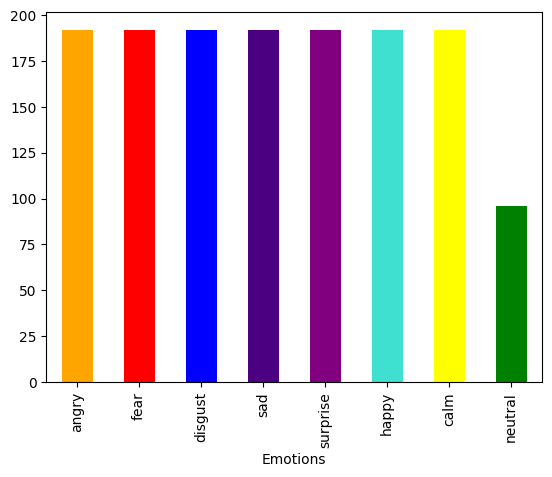

In [9]:
df["Emotions"].value_counts().plot(kind='bar',color={'red','blue','green','orange','yellow','purple','indigo','turquoise'})

/Users/darrylssy/Sites/slay-fake-news/mla-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darrylssy/Sites/slay-fake-news/mla-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darrylssy/Sites/slay-fake-news/mla-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darrylssy/Sites/slay-fake-news/mla-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

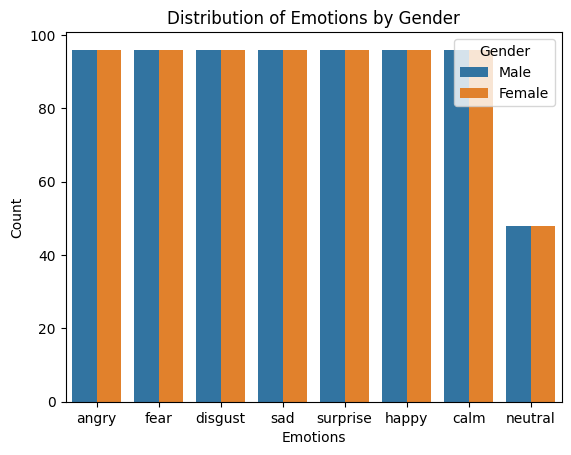

Emotions  Gender  Intensity
angry     0       0            48
                  1            48
surprise  1       0            48
          0       1            48
                  0            48
sad       1       1            48
                  0            48
          0       1            48
                  0            48
neutral   1       0            48
          0       0            48
happy     1       1            48
                  0            48
          0       1            48
                  0            48
fear      1       1            48
                  0            48
          0       1            48
                  0            48
disgust   1       1            48
                  0            48
          0       1            48
                  0            48
calm      1       1            48
                  0            48
          0       1            48
                  0            48
angry     1       1            48
                  0 

In [10]:
sns.countplot(x='Emotions', hue='Gender', data=df) #ax
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions by Gender')
plt.legend(title='Gender', loc='upper right', labels=['Male','Female'])  
plt.show()

# Display count values on top of the bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')


df[['Emotions', 'Gender', 'Intensity']].value_counts()
# df['Line'].value_counts()

Data is evenly distributed except "Neutral" emotion has half the number of samples as there is no "Strong" emotional intensity for "Neutral" 

### View Waveforms

In [11]:
#helper functions
def create_waveform(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Amplitude waveform for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
        

def create_spectrogram(data, sr, e): #use mel-spectro instead?
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram (Pitch) for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log') #log is better for differentiating - mel-spectrogram
    plt.colorbar()
        

#df is global variable
def show(emotion):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveform(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

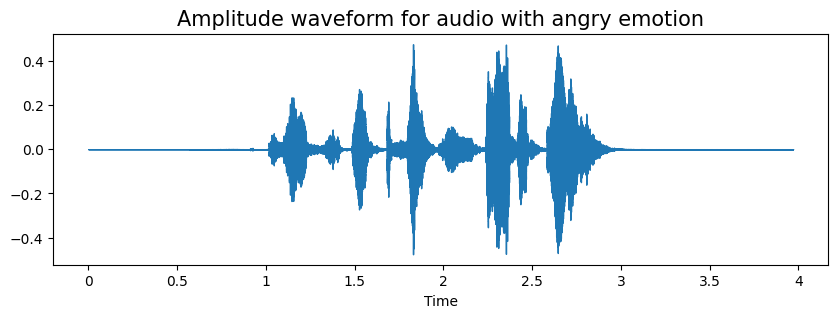

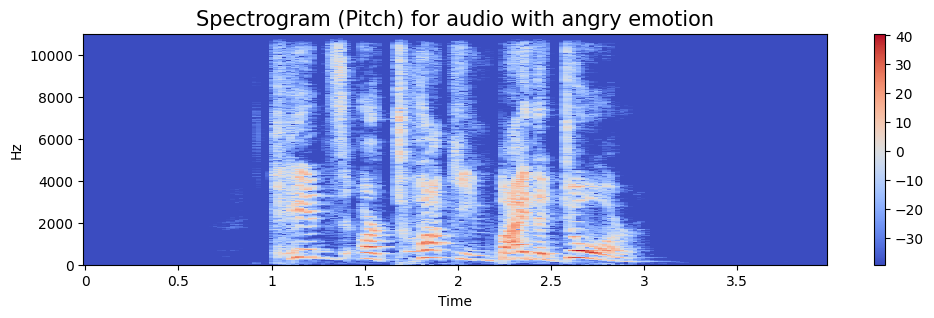

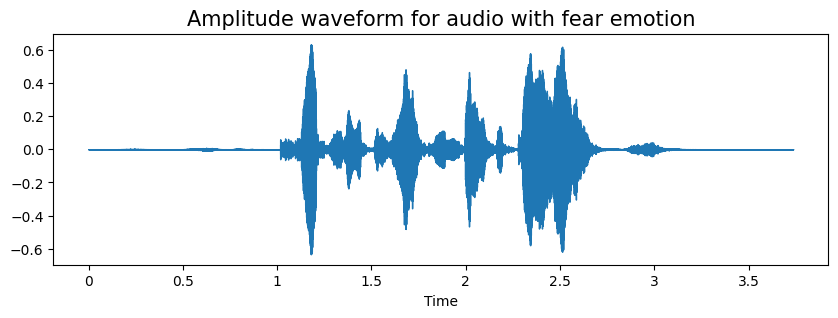

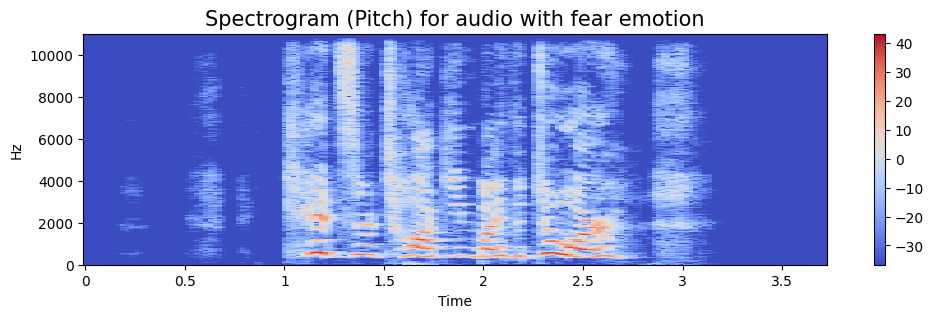

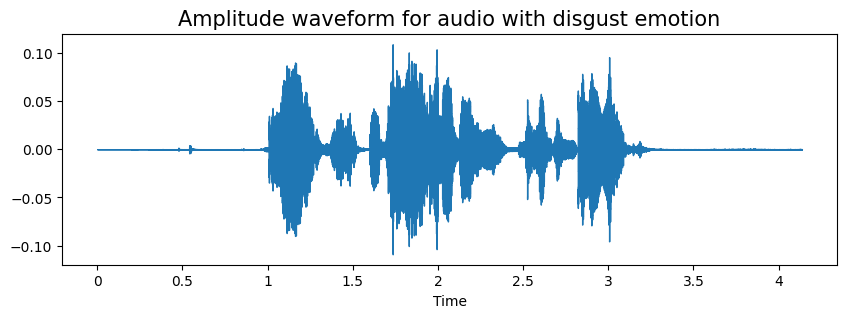

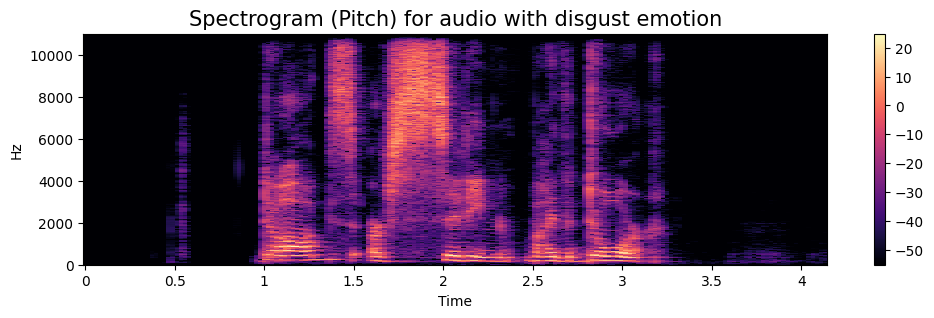

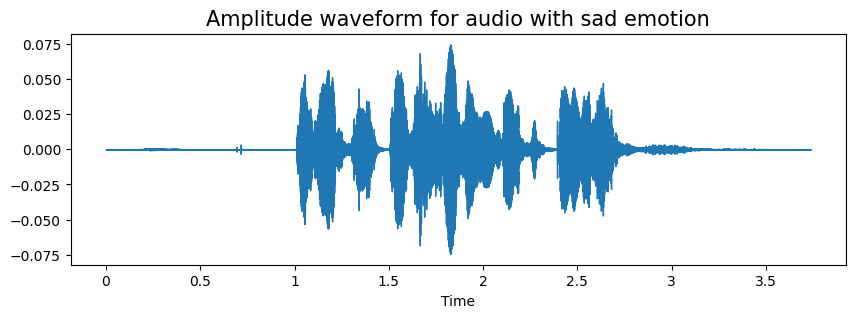

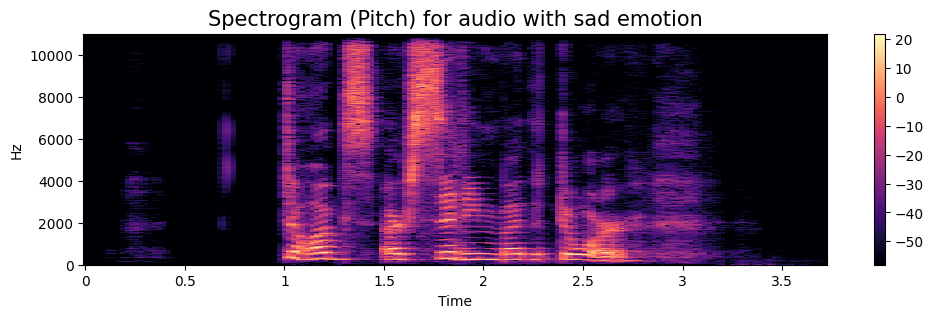

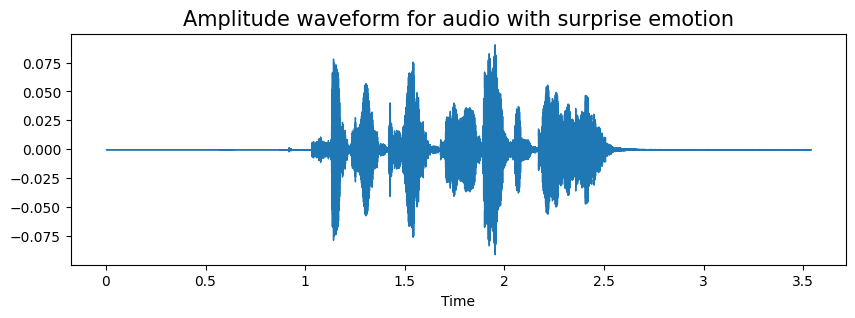

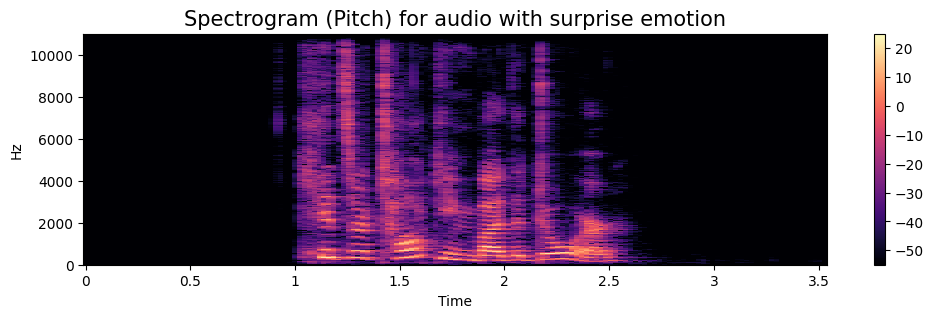

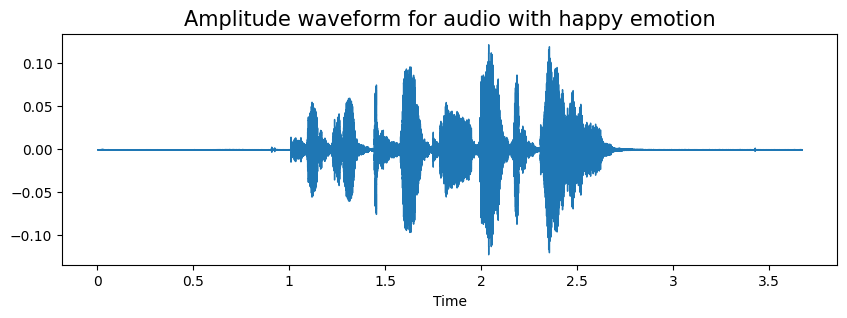

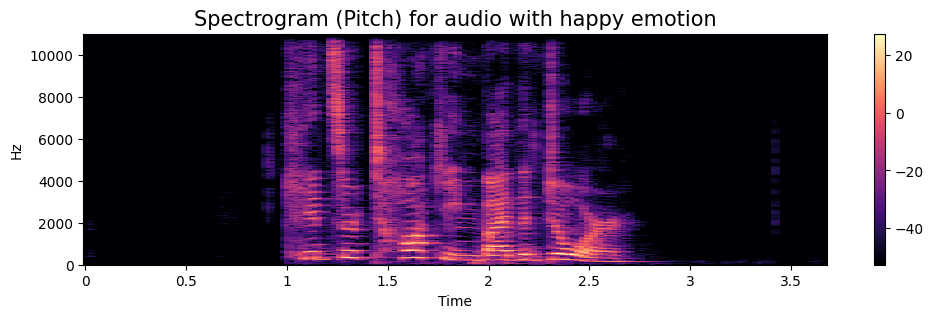

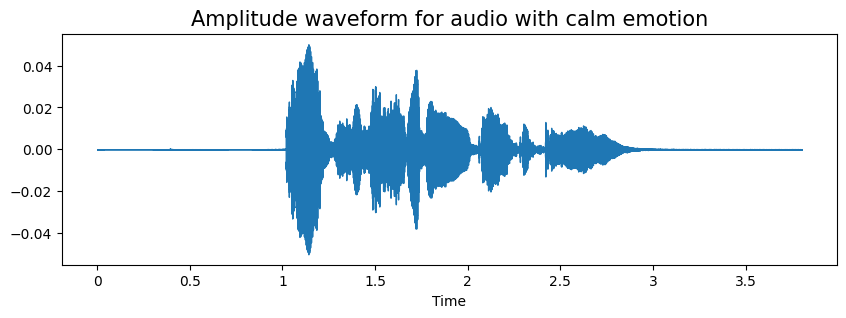

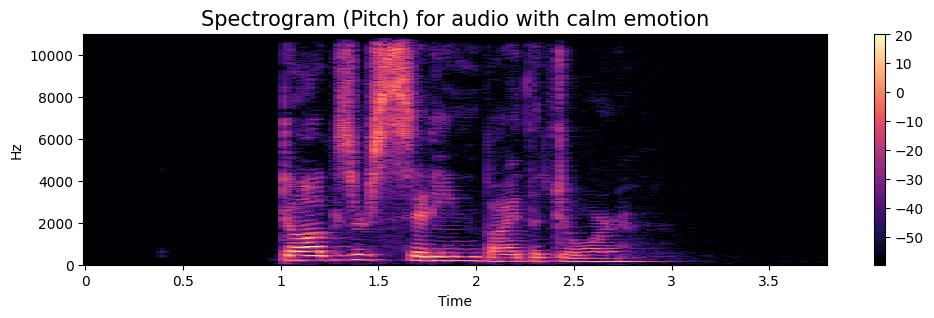

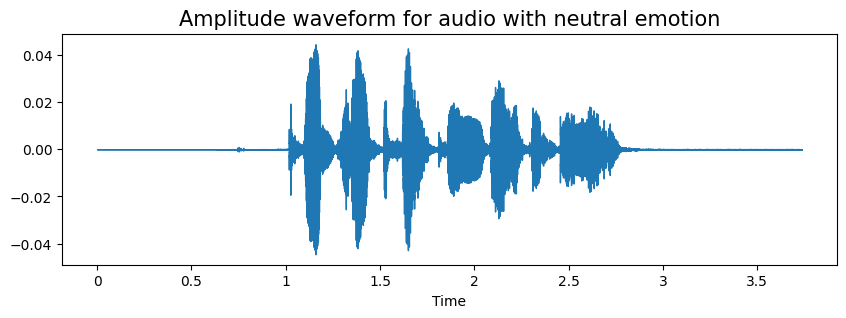

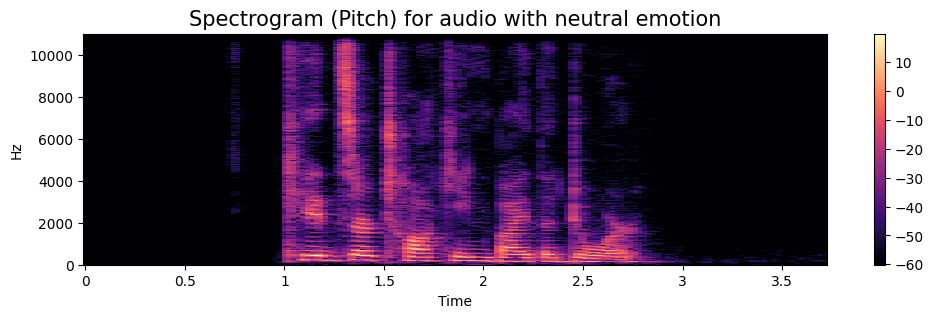

In [12]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    show(emotion)

### Comparitive MFCC waveform

In [13]:
# generates line plot of mean pitch 

def amp_wave(emotion, gender):
    path = df[(df['Emotions'] == emotion) & (df['Gender'] == gender)]['Path'].iloc[1]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) 
    fig = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    fig = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    return fig

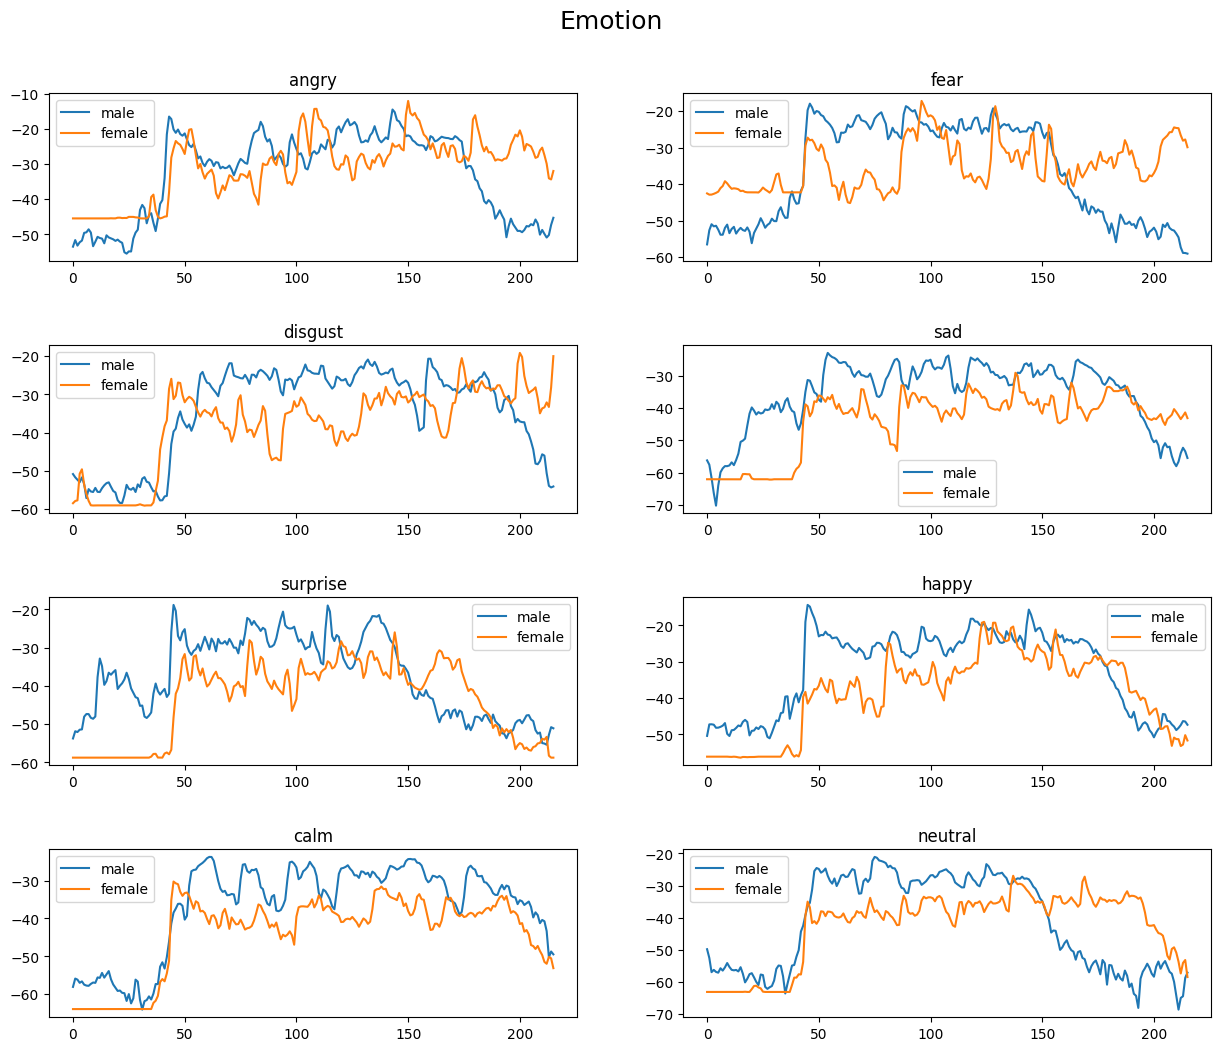

In [14]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Emotion", fontsize=18, y=0.95)
nrows = round(len(all_emotions)/2)

for i, emotion in enumerate(all_emotions):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, 2, i + 1)

    plt.plot(amp_wave(emotion, 0),  label='male')
    plt.plot(amp_wave(emotion, 1),  label='female')
    plt.legend()
    ax.set_title(emotion)


## Amplitude Envelope Feature


In [15]:
def amplitude_envelope(emotion, frame_size, hop_len, visualise=True):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    signal, sr = librosa.load(path)
    ae = np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_len)])
    
    frames = range(0, len(ae))
    times = librosa.frames_to_time(frames, hop_length = hop_len)
    
    if visualise == True:
        plt.figure(figsize=(10,6))
        librosa.display.waveshow(signal, alpha=0.5)
        plt.plot(times, ae, color='r')
        plt.title(emotion + " Amplitude Envelope")
        plt.show()
    
    return ae


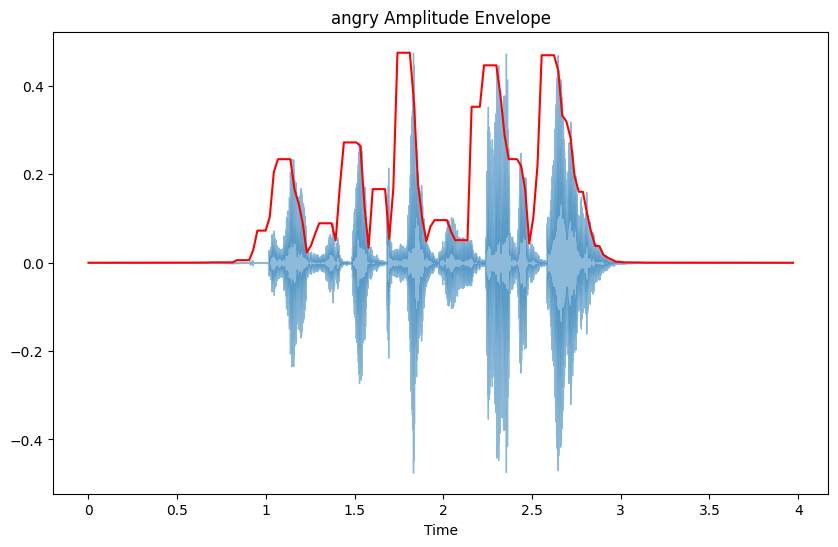

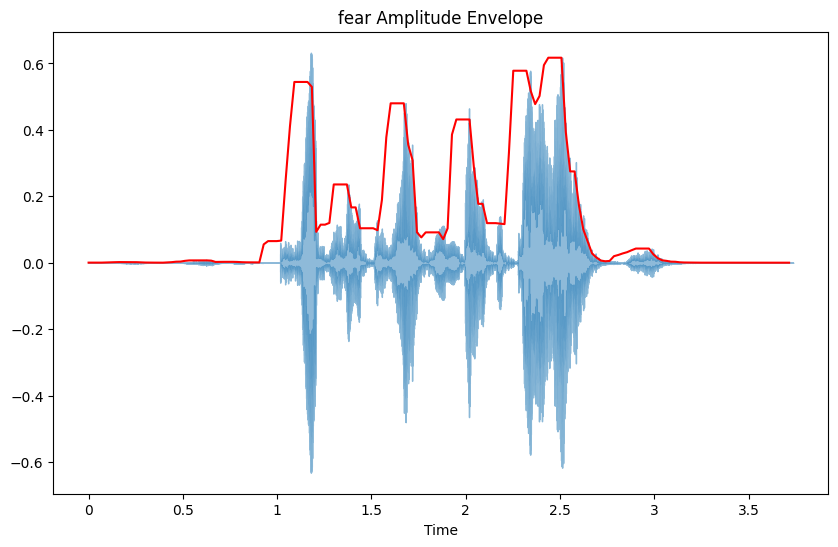

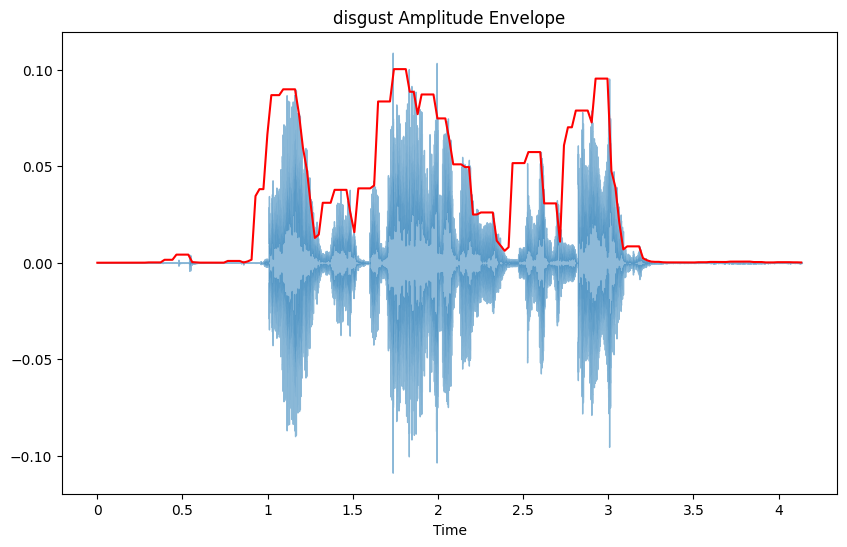

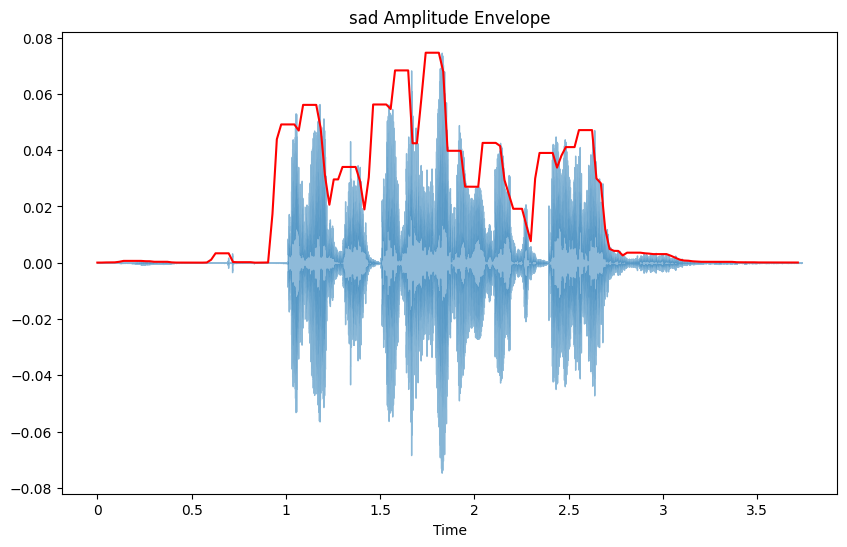

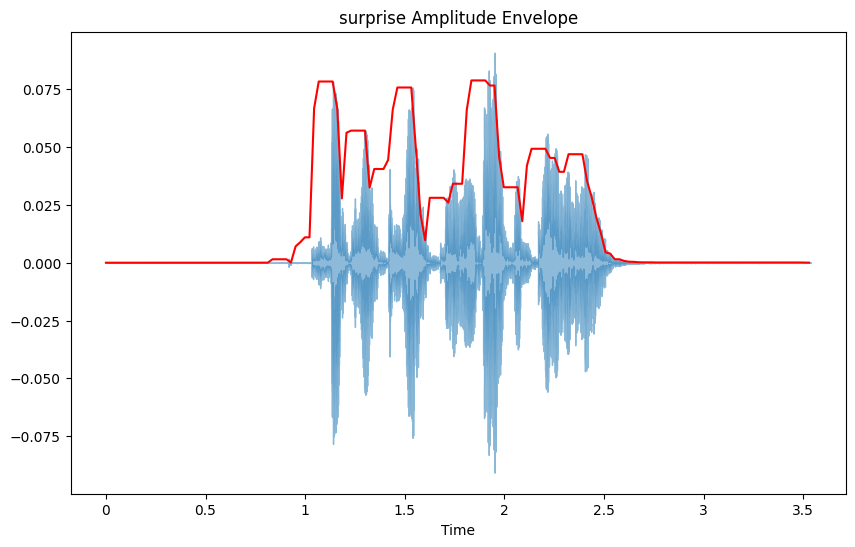

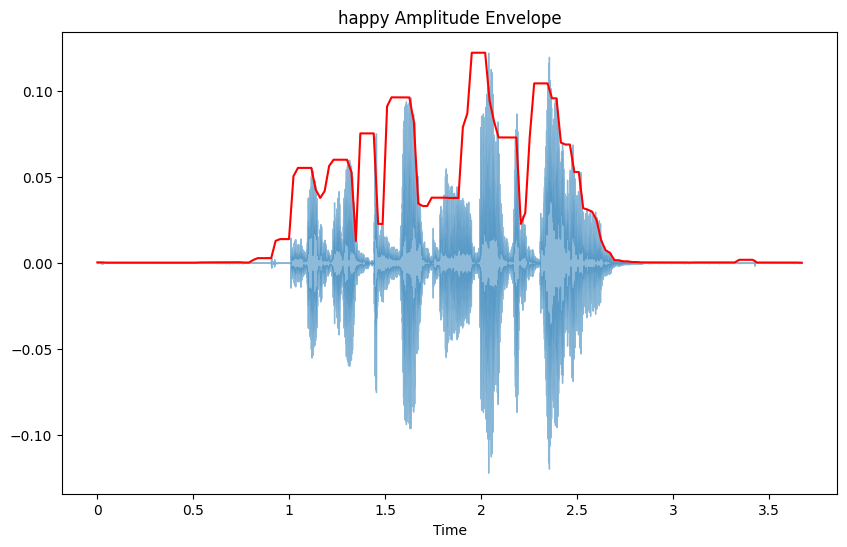

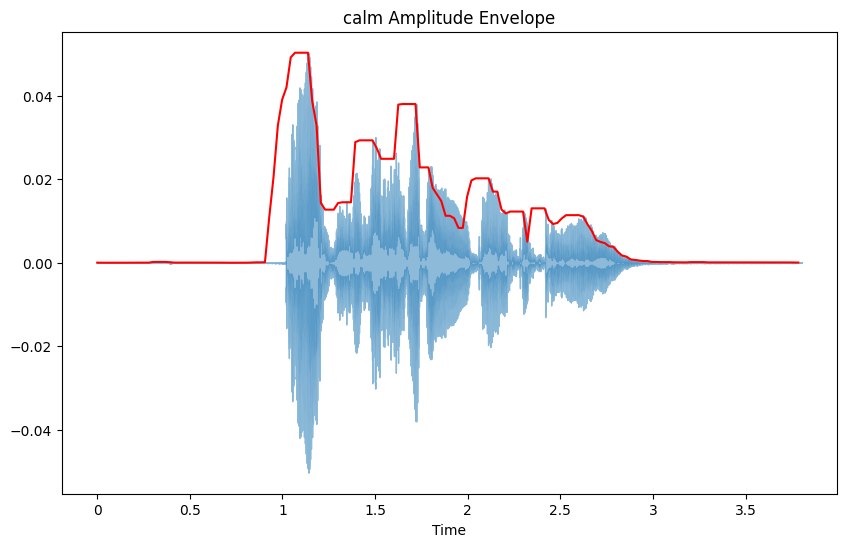

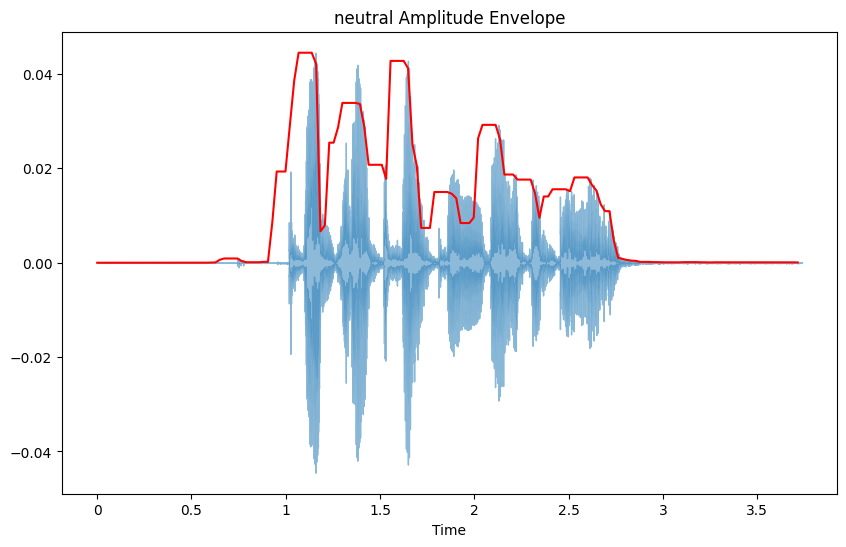

In [16]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    amplitude_envelope(emotion, frame_size=2048, hop_len=512)

Other metrics for amplitude
- root mean square energy
- zero crossing rate

And other metrics here 

- https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
- https://jonathan-hui.medium.com/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9

In [17]:
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

# Data Augmentation

In [4]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

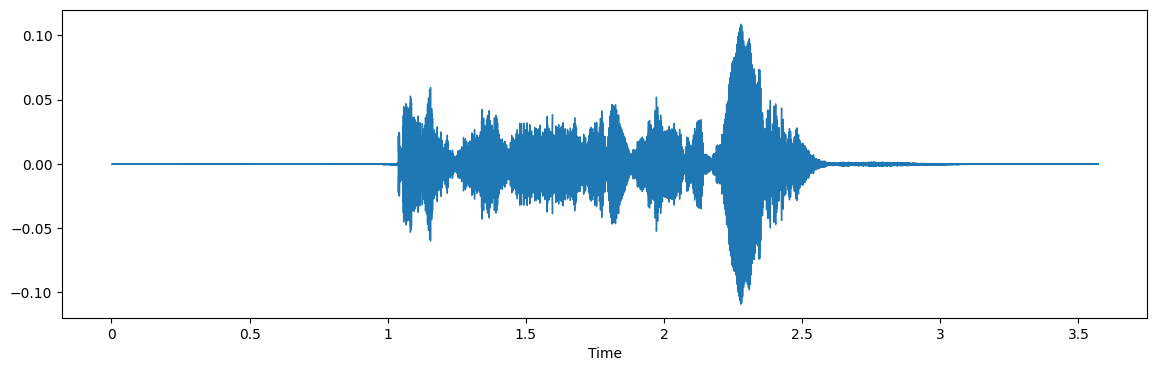

In [19]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [51]:
# from pyAudioAnalysis import audioBasicIO
# from pyAudioAnalysis import MidTermFeatures
# import matplotlib.pyplot as plt

# path = df.at[30, "Path"]
# print(df.at[30, "Emotions"])
# test = np.array([])
# [Fs, x] = audioBasicIO.read_audio_file(path)
# F,Fshort, f_names = MidTermFeatures.mid_feature_extraction(x, Fs, 0.50*Fs, 0.25*Fs, 0.050*Fs, 0.025*Fs)

# #Extract features 1-21, 34
# for f in F[:20]+F[33]:
#     #Stack/stitch 12 frames together
#     f = f[12//2-6:12//2+6]
#     test = np.hstack((test,f))
    


angry


c:\Users\Huai\Documents\GitHub\is460-g2\venv\lib\site-packages\pyAudioAnalysis\audioBasicIO.py:99: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, signal = wavfile.read(input_file) # from scipy.io


In [23]:



# def extract_features(data, sample_rate):
#     print(sample_rate)
#     # ZCR
#     result = np.array([])
#     F,Fshort, f_names = MidTermFeatures.mid_feature_extraction(data, sample_rate, 0.50*sample_rate, 0.25*sample_rate, 0.050*sample_rate, 0.025*sample_rate)
#     #Extract features 1-21, 34
#     for f in F[:20]+F[33]:
#         #Stack/stitch 12 frames together
#         f = f[12//2-6:12//2+6]
#         result = np.hstack((result,f))
#     return result


# def get_features(path):
#     # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     sample_rate, data = audioBasicIO.read_audio_file(path)
#     print(sample_rate)
#     # without augmentation
#     res1 = extract_features(data,sample_rate)
#     result = np.array(res1)
    
#     # data with noise
#     noise_data = noise(data)
#     res2 = extract_features(noise_data,sample_rate)
#     result = np.vstack((result, res2)) # stacking vertically
    
#     # data with stretching and pitching
#     # new_data = stretch(data)
#     # data_stretch_pitch = pitch(new_data, sample_rate)
#     # res3 = extract_features(data_stretch_pitch,sample_rate)
#     # result = np.vstack((result, res3)) # stacking vertically
    
#     return result



def extract_features(data, sample_rate):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    # Spectral Centroid
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroids))

    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))

    # Chroma Deviation
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_std))

    return result

def get_features(path):
    hstack = None
    step = 5
    for i in range(0,30,step):
        
        if i == 0:
            offset=0
        else:
            i/=10
            offset = i-step/10
        print(i,offset)
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
        data, sample_rate = librosa.load(path, offset=offset, duration=step/10)
        print(data)
    
        # without augmentation
        res1 = extract_features(data,sample_rate)
        result = np.array(res1)
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data,sample_rate)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch,sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        if i == 0:
            hstack = result
        else: hstack = np.hstack((hstack,result))
        print(hstack.shape)
        
    return hstack

In [24]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

0 0
[ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09 ... -9.7289310e-14
  5.3623948e-14  4.0833775e-13]
(3, 184)
0.5 0.0
[ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09 ... -9.7289310e-14
  5.3623948e-14  4.0833775e-13]
(3, 368)
1.0 0.5
[ 1.6773167e-13 -1.4139693e-13 -1.6674535e-14 ... -2.4912157e-05
 -1.3756729e-05 -8.2513025e-06]
(3, 552)
1.5 1.0
[-3.1992196e-05 -8.7088993e-05 -8.2679748e-05 ...  5.9846533e-04
  6.0554000e-04  7.6285709e-04]
(3, 736)
2.0 1.5
[0.00071081 0.00174738 0.00291066 ... 0.00209488 0.00219533 0.00288344]
(3, 920)
2.5 2.0
[ 2.0491257e-03  3.5165688e-03  3.7435028e-03 ... -4.3936745e-07
  3.6242292e-07 -2.9281787e-07]
(3, 1104)
0 0
[-2.6555711e-06 -1.2237584e-05 -9.1077754e-07 ... -2.1457981e-06
  1.3691682e-05  2.3177893e-06]
(3, 184)
0.5 0.0
[-2.6555711e-06 -1.2237584e-05 -9.1077754e-07 ... -2.1457981e-06
  1.3691682e-05  2.3177893e-06]
(3, 368)
1.0 0.5
[ 1.0144345e-06 -2.3722143e-06  1.1701193e-05 ...  6.8651119e-05
  4.8622052e-05  5.9911799e-05]
(3, 552)
1.5 1.

c:\Users\Huai\Documents\GitHub\is460-g2\venv\lib\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.8708698e-06 5.7090721e-05
 1.1585455e-05]
(3, 552)
1.5 1.0
[ 7.7353852e-06  3.8297178e-05  2.8701685e-05 ...  4.5007520e-04
 -5.3647102e-04 -1.9803164e-03]
(3, 736)
2.0 1.5
[-0.00208362 -0.00372468 -0.00346799 ... -0.00319195 -0.00301307
 -0.00332596]
(3, 920)
2.5 2.0
[-0.00214478 -0.00323702 -0.00288592 ...  0.00182811  0.00146988
  0.00101279]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[9.2457932e-15 9.3688939e-14 4.6156621e-15 ... 4.2644009e-05 2.7379869e-05
 2.7289310e-05]
(3, 552)
1.5 1.0
[ 3.3889737e-05  5.7353682e-05  5.3596337e-05 ... -1.9323230e-03
  6.5055402e-04  2.4087320e-03]
(3, 736)
2.0 1.5
[ 9.8803523e-04  9.2546165e-04 -8.7017354e-05 ... -5.4617450e-03
 -4.1930215e-03 -2.1911729e-03]
(3, 920)
2.5 2.0
[ 2.8565939e-04  2.2812127e-03  3.7969430e-03 ... -1.6652430e-04
 -1.8629566e-05  2.2444502e-04]
(3, 1104)
0 0
[-

In [27]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

In [98]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features2.csv', index=False)

Features = pd.read_csv("features2.csv")
Features.head()

0         1         2         3         4         5         6  \
0  0.482244  0.898372  0.890423  0.894151  0.944192  0.859793  0.749153   
1  0.514160  0.901068  0.893363  0.945462  0.925806  0.822909  0.759040   
2  0.432653  0.892484  0.877763  0.865350  0.856979  0.804634  0.724282   
3  0.625954  0.885089  0.869817  0.951720  0.960158  0.888712  0.781182   
4  0.499578  0.883187  0.868787  0.953181  0.959511  0.891645  0.791023   

          7         8         9  ...      1095      1096      1097      1098  \
0  0.750251  0.782538  0.808899  ...  0.185524  0.255634  0.305313  0.223040   
1  0.777880  0.799651  0.800747  ...  0.247094  0.273687  0.317839  0.230420   
2  0.757181  0.761056  0.824375  ...  0.169478  0.150814  0.287546  0.335427   
3  0.743050  0.748825  0.757791  ...  0.224509  0.182424  0.243763  0.237517   
4  0.743202  0.744295  0.757687  ...  0.218453  0.197505  0.249026  0.232084   

       1099      1100      1101      1102      1103   labels  
0  0.209102  0.232945  0.214891  0.199323  0.225353  neutral  
1  0.197733  0.215420  0.227133  0.143829  0.222544  neutral  
2  0.222965  0.203022  0.211530  0.193576  0.178151  neutral  
3  0.200946  0.204546  0.216371  0.192921  0.201386  neutral  
4  0.193301  0.206707  0.215919  0.185637  0.203190  neutral  

[5 rows x 1105 columns]

# Data Preparation

In [99]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [100]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [101]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [102]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [103]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104, 1), (3240, 8), (1080, 1104, 1), (1080, 8))

# Modelling

In [113]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='sigmoid'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy','mse'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 1104, 256)         1536      
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 552, 256)         0         
 g1D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 552, 256)          0         
                                                                 
 conv1d_61 (Conv1D)          (None, 552, 256)          327936    
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 276, 256)         0         
 g1D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 276, 256)        

In [114]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
# print(tf.test.is_built_with_cudnn())

True


In [115]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.8, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
26/26 [==============================] - 2s 41ms/step - loss: 2.0245 - accuracy: 0.1889 - mse: 0.2524 - val_loss: 1.9559 - val_accuracy: 0.2528 - val_mse: 0.2424 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 32ms/step - loss: 1.9539 - accuracy: 0.2198 - mse: 0.2520 - val_loss: 2.0246 - val_accuracy: 0.2472 - val_mse: 0.2457 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 31ms/step - loss: 1.9255 - accuracy: 0.2321 - mse: 0.2552 - val_loss: 2.0016 - val_accuracy: 0.2787 - val_mse: 0.2448 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 31ms/step - loss: 1.8734 - accuracy: 0.2630 - mse: 0.2678 - val_loss: 2.0653 - val_accuracy: 0.3370 - val_mse: 0.2505 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 32ms/step - loss: 1.8333 - accuracy: 0.2864 - mse: 0.2716 - val_loss: 2.0515 - val_accuracy: 0.3907 - val_mse: 0.2472 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 32ms/step

34/34 [==============================] - 0s 9ms/step - loss: 0.8801 - accuracy: 0.7083 - mse: 0.2626
Accuracy of our model on test data :  70.83333134651184 %


ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

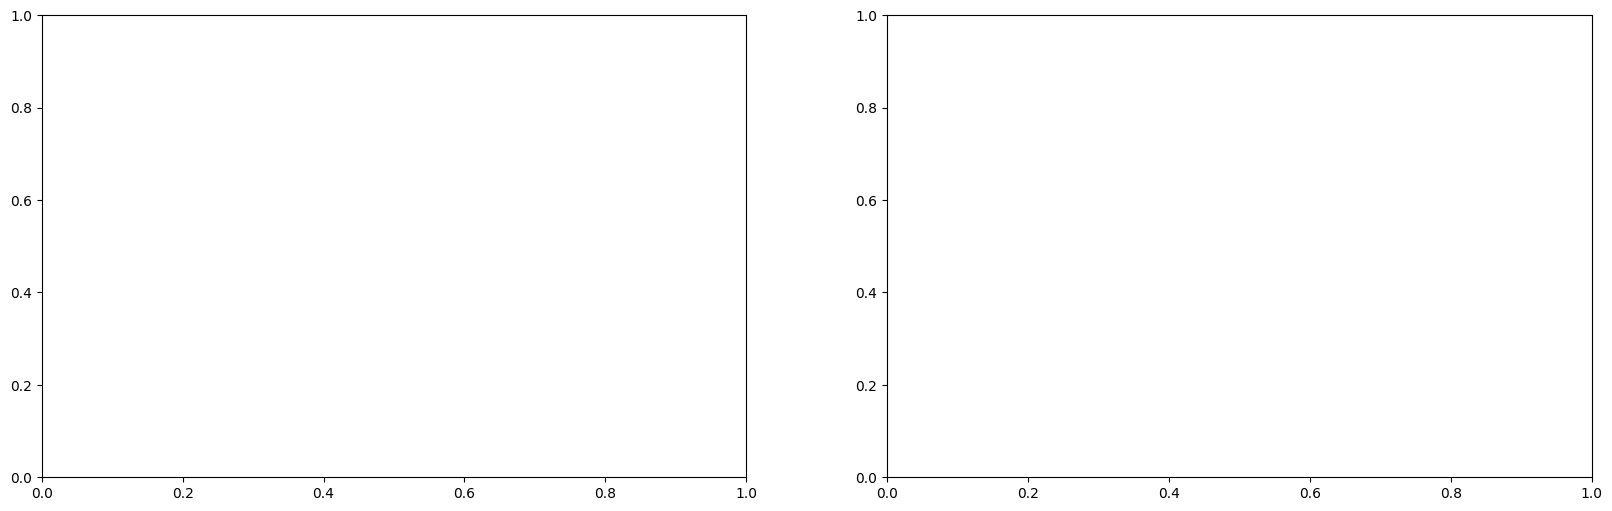

In [116]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [117]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 13ms/step


In [118]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1          disgust         angry
2             fear          fear
3             calm          calm
4            angry         angry
5         surprise      surprise
6              sad          fear
7             fear         happy
8             fear          fear
9              sad           sad

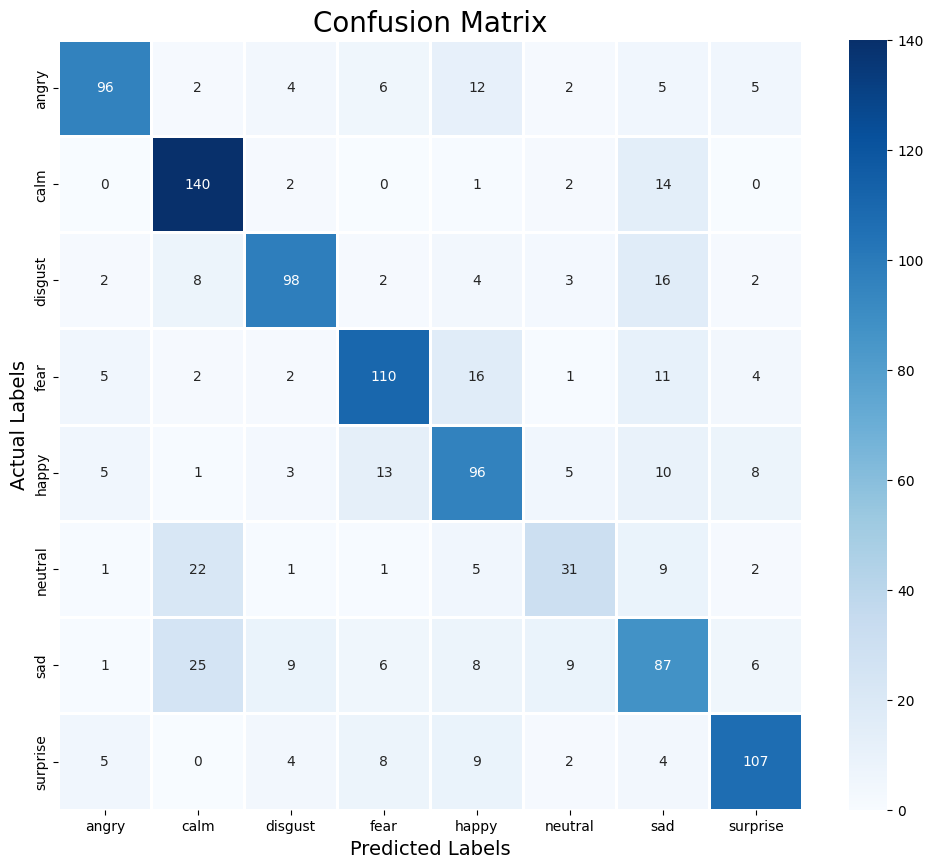

In [119]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.83      0.73      0.78       132
        calm       0.70      0.88      0.78       159
     disgust       0.80      0.73      0.76       135
        fear       0.75      0.73      0.74       151
       happy       0.64      0.68      0.66       141
     neutral       0.56      0.43      0.49        72
         sad       0.56      0.58      0.57       151
    surprise       0.80      0.77      0.78       139

    accuracy                           0.71      1080
   macro avg       0.71      0.69      0.69      1080
weighted avg       0.71      0.71      0.71      1080

